Dataset shape: (8737, 4)
                     temperature   humidity  appliances      usage
date                                                              
2021-01-01 00:00:00    22.483571  47.607269           6  14.766854
2021-01-01 01:00:00    19.308678  64.781212           5  20.160930
2021-01-01 02:00:00    23.238443  35.176032           4   8.766073
2021-01-01 03:00:00    27.615149  42.486545           5   7.385079
2021-01-01 04:00:00    18.829233  65.200917           4  16.680251
Final dataset shape after feature engineering: (8734, 10)
Train shape: (6987, 9)
Test shape: (1747, 9)
Linear Regression RMSE: 2.0166844147493386
Random Forest RMSE: 2.1978602659340414
XGBoost RMSE: 2.1647108347386794


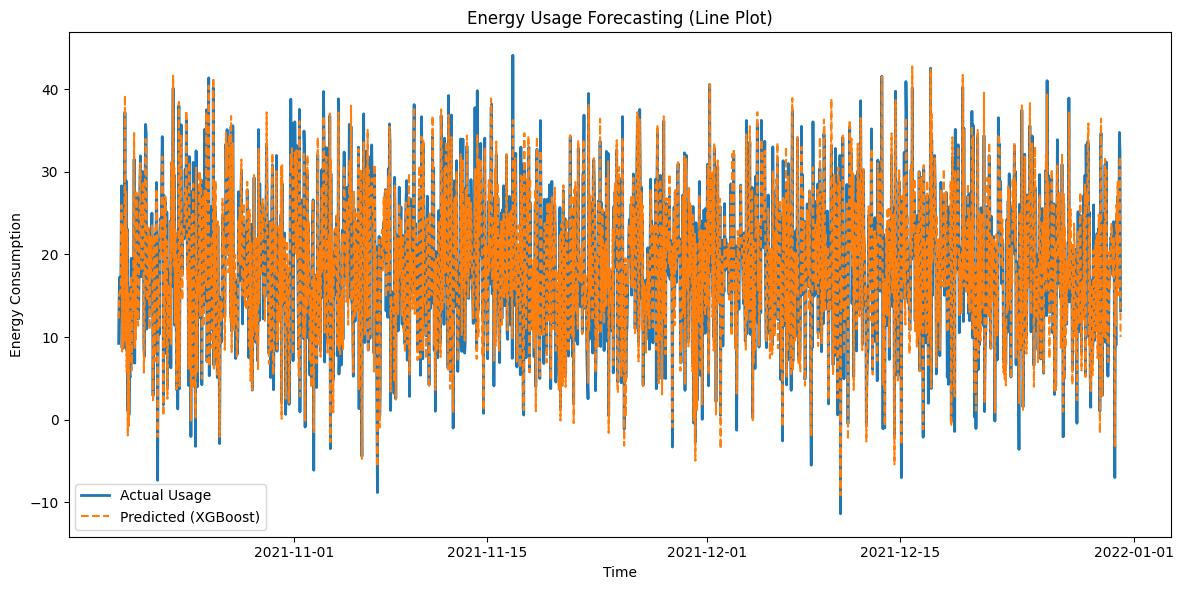

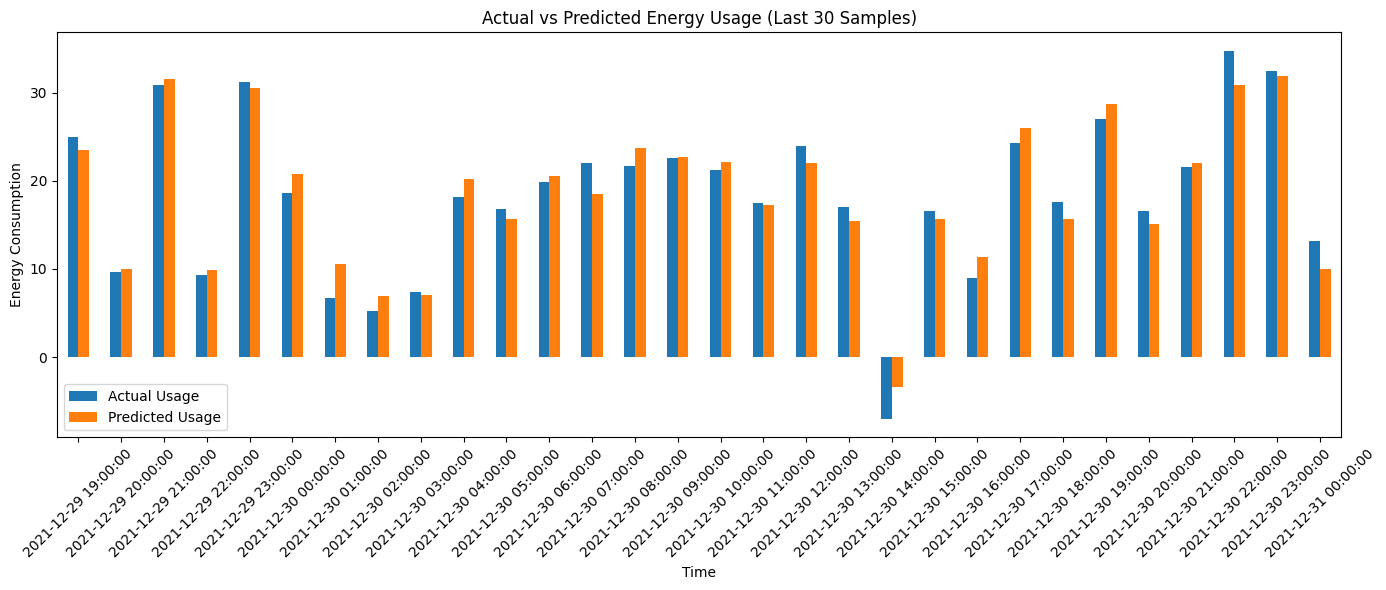

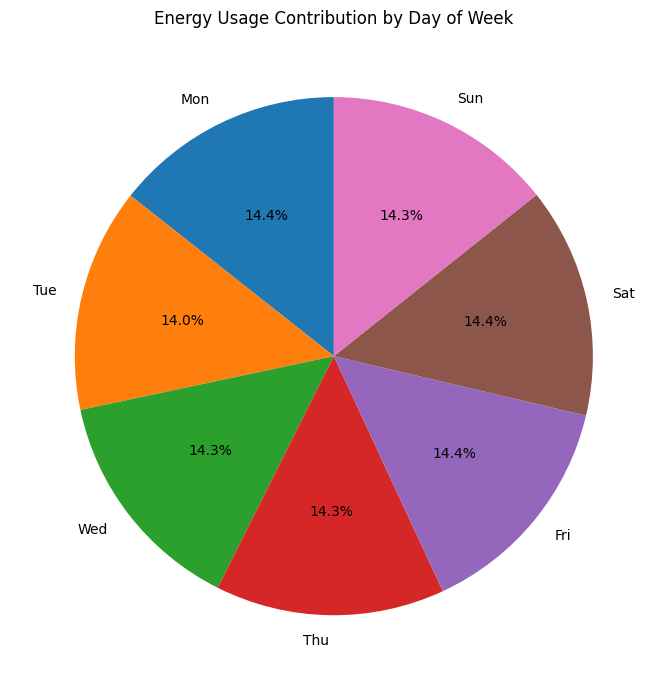

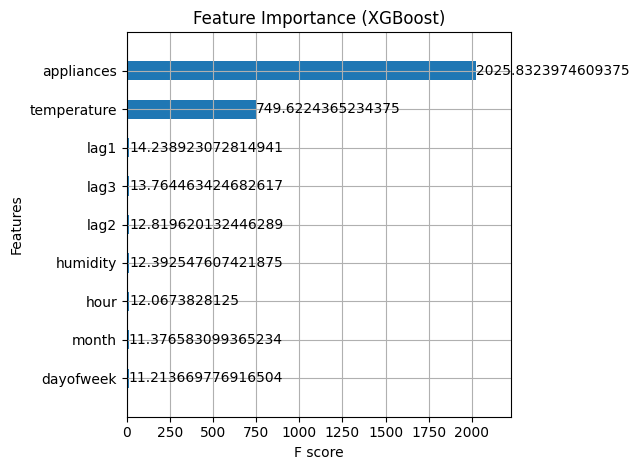

In [1]:
# =====================================
# Energy Usage Forecaster (Regression + Time Series + Visual Insights)
# =====================================

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# -------------------------------------
# 2. Load Dataset
# -------------------------------------
# Expected format: date, temperature, humidity, appliances, usage
data = pd.read_csv("energy.csv", parse_dates=['date'])
data.set_index('date', inplace=True)

print("Dataset shape:", data.shape)
print(data.head())

# -------------------------------------
# 3. Feature Engineering
# -------------------------------------
# Extract temporal features
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

# Create lag features
data['lag1'] = data['usage'].shift(1)
data['lag2'] = data['usage'].shift(2)
data['lag3'] = data['usage'].shift(3)

# Drop rows with NaNs after lagging
data.dropna(inplace=True)

print("Final dataset shape after feature engineering:", data.shape)

# -------------------------------------
# 4. Train-Test Split
# -------------------------------------
X = data.drop("usage", axis=1)
y = data["usage"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# -------------------------------------
# 5. Baseline Model - Linear Regression
# -------------------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse_lr)

# -------------------------------------
# 6. Random Forest Regressor
# -------------------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)

# -------------------------------------
# 7. XGBoost Regressor
# -------------------------------------
xg_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xg_reg.fit(X_train, y_train)
y_pred_xgb = xg_reg.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)

# -------------------------------------
# 8. Visualization - Actual vs Predicted (Line Plot)
# -------------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Usage", linewidth=2)
plt.plot(y_test.index, y_pred_xgb, label="Predicted (XGBoost)", linestyle="--")
plt.title("Energy Usage Forecasting (Line Plot)")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------
# 9. Enhanced Bar Chart - Actual vs Predicted
# -------------------------------------
# Take a small sample (e.g., last 30 records) for clarity
bar_data = pd.DataFrame({
    "Actual Usage": y_test[-30:].values,
    "Predicted Usage": y_pred_xgb[-30:]
}, index=y_test[-30:].index)

bar_data.plot(kind="bar", figsize=(14,6))
plt.title("Actual vs Predicted Energy Usage (Last 30 Samples)")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------------
# 10. Pie Chart - Usage Contribution by Day of Week
# -------------------------------------
day_usage = data.groupby("dayofweek")["usage"].sum()
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(7,7))
plt.pie(day_usage, labels=day_labels, autopct='%1.1f%%', startangle=90)
plt.title("Energy Usage Contribution by Day of Week")
plt.tight_layout()
plt.show()

# -------------------------------------
# 11. Feature Importance (XGBoost)
# -------------------------------------
xgb.plot_importance(xg_reg, importance_type="gain", height=0.5)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()
